# Chapter 5 - AutoRegressive Integrated Moving Average (ARIMA) Models

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from statsmodels.tools.eval_measures import rmspe, rmse
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima_process import ArmaProcess
from pmdarima.arima import CHTest
from pmdarima.arima import ndiffs


import warnings
warnings.filterwarnings('ignore')

## 5.39 Table B.21 contains data from the US Energy Information Administration 
on monthly average price of electricity for the residential sector in Arizona. This data has a strong seasonal component. Use the data from 2001–2010 to develop an ARIMA model for this data. Use this model to simulate one-month-ahead forecasts for the remaining years. Calculate the forecast errors. Discuss the reasonableness of the forecasts.

In [3]:
# Define the data as a dictionary
data = {
    'Year': [
        2001, 2002, 2003, 2004, 2005, 2006, 2007,
        2008, 2009, 2010, 2011, 2012, 2013, 2014
    ],
    'Jan': [6.99, 7.01, 7.06, 7.27, 7.75, 8.05, 8.33, 8.85, 9.51, 9.57, 9.84, 10.01, 10.25, 10.92],
    'Feb': [7.13, 7.17, 7.57, 7.49, 7.99, 8.21, 8.46, 9.02, 9.82, 9.84, 9.93, 10.26, 10.70, 11.23],
    'Mar': [7.40, 7.46, 7.59, 7.61, 8.19, 8.38, 8.80, 9.38, 9.93, 9.98, 10.25, 10.44, 10.87, 11.32],
    'Apr': [8.09, 7.69, 7.82, 8.05, 8.67, 8.92, 9.19, 10.02, 10.65, 10.24, 10.97, 11.17, 11.74, 11.97],
    'May': [9.41, 9.37, 9.52, 9.26, 9.60, 10.19, 10.20, 11.03, 11.33, 11.75, 11.77, 11.88, 12.17, None],
    'Jun': [9.04, 8.97, 9.09, 9.10, 9.41, 10.05, 9.96, 11.06, 11.27, 11.74, 11.77, 11.90, 12.18, None],
    'Jul': [8.84, 8.65, 8.78, 8.88, 9.30, 9.90, 10.37, 10.95, 11.30, 11.78, 11.85, 11.86, 12.51, None],
    'Aug': [8.84, 8.78, 8.74, 8.87, 9.28, 9.88, 10.33, 10.86, 11.29, 11.59, 11.67, 11.83, 12.33, None],
    'Sep': [8.81, 8.79, 8.70, 8.96, 9.30, 9.89, 10.17, 10.63, 11.17, 11.52, 11.53, 11.66, 12.22, None],
    'Oct': [8.95, 8.99, 8.83, 8.79, 9.23, 9.88, 10.16, 10.46, 10.97, 10.96, 11.08, 11.36, 12.02, None],
    'Nov': [7.17, 7.37, 7.21, 8.05, 8.12, 8.74, 9.08, 9.55, 9.86, 10.14, 10.31, 10.73, 11.06, None],
    'Dec': [7.26, 7.46, 7.55, 7.86, 7.88, 8.56, 8.89, 9.61, 9.70, 10.00, 9.98, 10.41, 11.01, None]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Melt into long format
df_long = df.melt(id_vars='Year', var_name='Month', value_name='Cents_per_kWh')

# Combine Year and Month into datetime
df_long['Date'] = pd.to_datetime(df_long['Month'] + '-' + df_long['Year'].astype(str), format='%b-%Y')

# Set index and sort
df_long = df_long.set_index('Date').sort_index()

# Drop extra columns
df_final = df_long[['Cents_per_kWh']]

# Display
df_final

,Cents_per_kWh
Date,
2001-01-01,6.99
2001-02-01,7.13
2001-03-01,7.40
2001-04-01,8.09
2001-05-01,9.41
...,...
2014-08-01,NaN
2014-09-01,NaN
2014-10-01,NaN


In [4]:
# Drop the last 8 values
df_final_trimmed = df_final.iloc[:-8]

# Display the result
df_final_trimmed.tail()

,Cents_per_kWh
Date,
2013-12-01,11.01
2014-01-01,10.92
2014-02-01,11.23
2014-03-01,11.32
2014-04-01,11.97


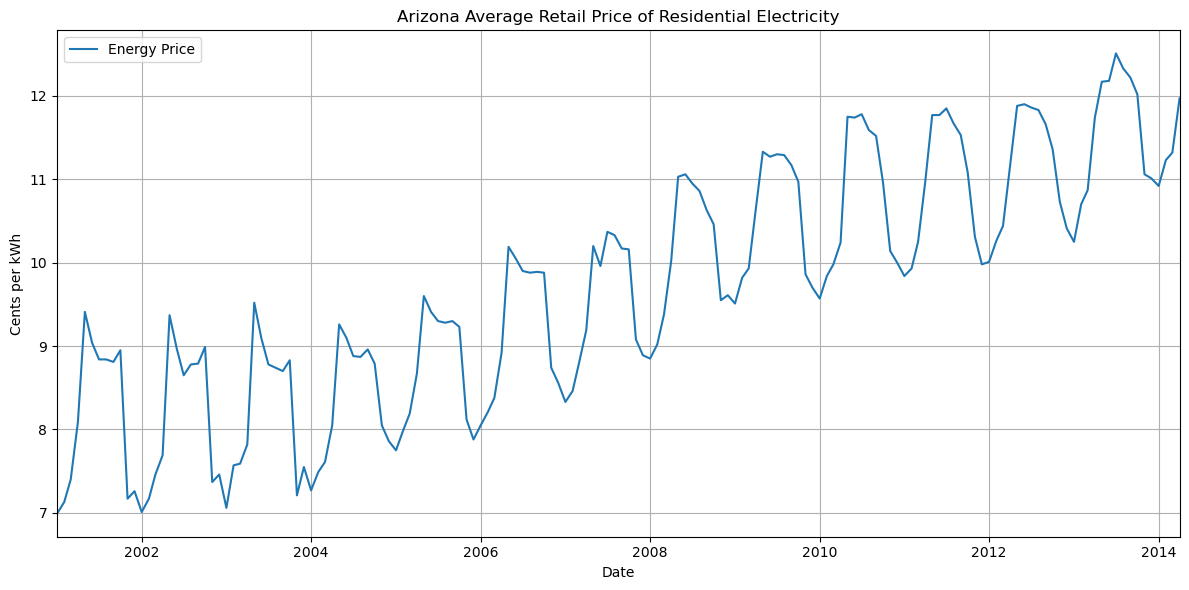

In [5]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

plt.plot(df_final_trimmed.index, df_final_trimmed['Cents_per_kWh'], label='Energy Price')     

plt.title('Arizona Average Retail Price of Residential Electricity')                      
plt.xlabel('Date')                                        
plt.ylabel('Cents per kWh')  
plt.xlim(pd.to_datetime('2001-01-01'), pd.to_datetime('2014-04-01'))
plt.grid(True)                                            
plt.legend()                                             
plt.tight_layout()                                       
plt.show();

In [6]:
# Split the data
train = df_final_trimmed[df_final_trimmed.index.year < 2012]     # All data before 2012
test = df_final_trimmed[df_final_trimmed.index.year >= 2012]     # All data in 2012 and beyond

# Show the results
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print()
train.tail(), print(), test.head()

Train shape: (132, 1)
Test shape: (28, 1)




(            Cents_per_kWh
 Date                     
 2011-08-01          11.67
 2011-09-01          11.53
 2011-10-01          11.08
 2011-11-01          10.31
 2011-12-01           9.98,
 None,
             Cents_per_kWh
 Date                     
 2012-01-01          10.01
 2012-02-01          10.26
 2012-03-01          10.44
 2012-04-01          11.17
 2012-05-01          11.88)

In [7]:
energy_series = train['Cents_per_kWh']

In [8]:
# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(energy_series)

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: 0.11665057527597042
p-value: 0.9671796908259176

p-value > alpha; H0: Not Stationary


In [9]:
# First-Order differencing
eps_diff = np.diff(energy_series, n=1)

ad_fuller_result1 = adfuller(eps_diff)

print(f'ADF Statistic: {ad_fuller_result1[0]}')
print(f'p-value: {ad_fuller_result1[1]}')
print()

if ad_fuller_result1[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -2.7643484866403902
p-value: 0.06354954987948008

p-value > alpha; H0: Not Stationary


In [10]:
# Second-Order differencing
eps_diff2 = np.diff(eps_diff, n=1)

ad_fuller_result1 = adfuller(eps_diff2)

print(f'ADF Statistic: {ad_fuller_result1[0]}')
print(f'p-value: {ad_fuller_result1[1]}')
print()

if ad_fuller_result1[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -10.177618770356753
p-value: 6.826415443413671e-18

p-value < alpha; Ha: Stationary


    d = 2

In [11]:
from statsmodels.tsa.stattools import adfuller

def determine_nonseasonal_d(series, max_d=2, alpha=0.05):

    d = 0

    adf_result = adfuller(series)                # Run ADF test on the original series
    p_value = adf_result[1]
    print(f"d = {d} | ADF Statistic = {adf_result[0]:.4f}, p-value = {p_value:.4f}")

    if p_value < alpha:                          # If the original series is stationary
        
        return d
        
    else:
        while p_value > alpha and d < max_d:
            d += 1
            series = np.diff(series, n=1)        # Perform first-order differencing
            ad_fuller_result1 = adfuller(series)  
            p_value = ad_fuller_result1[1]
            print(f"d = {d} | ADF Statistic = {ad_fuller_result1[0]:.4f}, p-value = {p_value:.4f}")   
            
        return d  

d = determine_nonseasonal_d(energy_series)
print(f"\nNon-seasonal differencing term (d): {d}")

d = 0 | ADF Statistic = 0.1167, p-value = 0.9672
d = 1 | ADF Statistic = -2.7643, p-value = 0.0635
d = 2 | ADF Statistic = -10.1776, p-value = 0.0000

Non-seasonal differencing term (d): 2


In [12]:
from pmdarima.arima import nsdiffs


def determine_seasonal_D(series, m=12):
    
    # Get seasonal differencing terms using CH and OCSB tests
    D_ch = nsdiffs(series, m=m, test='ch')
    D_ocsb = nsdiffs(series, m=m, test='ocsb')

    if D_ch == D_ocsb:
        D = D_ch
        return D
    else:
        print(f'CH Test: D = {D_ch}, OCSB Test: D = {D_ocsb}')
        D = D_ch
        return D

D = determine_seasonal_D(energy_series, 12)
print(f'Seasonal differencing term (D): {D}')

Seasonal differencing term (D): 0


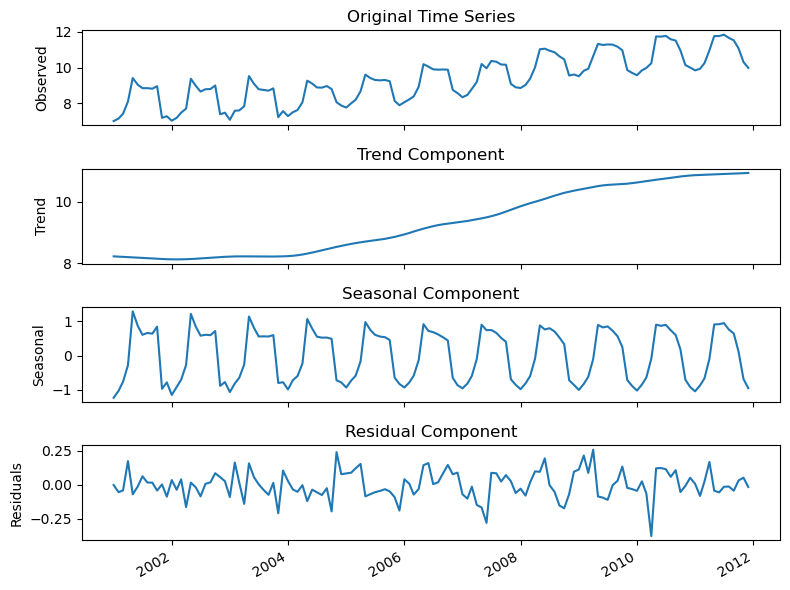

In [13]:
decom_air = STL(energy_series, period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(8,6))

ax1.plot(decom_air.observed)
ax1.set_ylabel('Observed')
ax1.set_title("Original Time Series")

ax2.plot(decom_air.trend)
ax2.set_ylabel('Trend')
ax2.set_title("Trend Component")

ax3.plot(decom_air.seasonal)
ax3.set_ylabel('Seasonal')
ax3.set_title("Seasonal Component")

ax4.plot(decom_air.resid)
ax4.set_ylabel('Residuals')
ax4.set_title("Residual Component")

fig.autofmt_xdate()
plt.tight_layout()
plt.show();

In [14]:
# Perform a full search over the same grid as your manual SARIMAX model
auto_model = pm.auto_arima(
    energy_series,              # The time series data
    seasonal=True,              # Enable seasonal component
    m=12,                       # 12 months (seasonal period)
    d=2,                        # Set differencing 
    D=0,                        # Set seasonal differencing
    start_p=0, max_p=3,         # p 
    start_q=0, max_q=3,         # q 
    start_P=0, max_P=3,         # P 
    start_Q=0, max_Q=3,         # Q 
    stepwise=False,             # Disable stepwise search (enable full grid search)
    trace=False,                # Print model search progress
    error_action='ignore',      # Ignore errors and continue
    suppress_warnings=True,     # Suppress convergence warnings
    information_criterion='aic' # Use AIC to choose the best model
)

# Print the best model found
print(f"Best model: SARIMA{auto_model.order}{auto_model.seasonal_order}")

Best model: SARIMA(0, 2, 2)(1, 0, 1, 12)


In [15]:
def combinator(items, r=1):
    combo = [i for i in product(*items, repeat=r)]  # Generate Cartesian product of input lists
    return combo                                    # Return the list of combinations


P_ns, Q_ns = [list(range(4))]*2          # Define search ranges for non-seasonal parameters (p, q): each from 0 to 3
P_s, Q_s = [list(range(4))]*2             # Define search ranges for seasonal parameters (P, Q): each from 0 to 3
d = 2
D = 0
S = 12

total = (P_ns[-1] + 1) * (Q_ns[-1] + 1) * (P_s[-1] + 1) * (Q_s[-1]+ 1)
print(f'Total number of models: {total}')

vals = combinator([P_ns, [d], Q_ns, P_s, [D], Q_s])  # Generate all combinations of SARIMA parameter sets

score = {}                                     # Dictionary to store model evaluation metrics

for i, (p, d, q, P, D, Q) in enumerate(vals):  # Iterate over all parameter combinations
    if i % 15 == 0:                            # Print progress every 15 models
        print(f'Running model #{i} using SARIMA({p},{d},{q})({P},{D},{Q},{S})')

    m = SARIMAX(energy_series,                 # Define SARIMA model with current parameter set
                order=(p,d,q), 
                seasonal_order=(P, D, Q, S),   
                enforce_stationarity=False)    # Allow non-stationary models for broader search

    res = m.fit(disp=0, low_memory=True)       # Fit the model silently

    score[i] = {                               # Store model results and evaluation metrics
        'non-seasonal order': (p, d, q),      
        'seasonal order': (P, D, Q),
        'AIC': res.aic,                        # Akaike Information Criterion
        'AICc': res.aicc,                      # Corrected AIC
        'model': res                           # Fitted model object
    }
print()

pd.DataFrame(score).T.sort_values(by='AIC').reset_index().head()

Total number of models: 256
Running model #0 using SARIMA(0,2,0)(0,0,0,12)
Running model #15 using SARIMA(0,2,0)(3,0,3,12)
Running model #30 using SARIMA(0,2,1)(3,0,2,12)
Running model #45 using SARIMA(0,2,2)(3,0,1,12)
Running model #60 using SARIMA(0,2,3)(3,0,0,12)
Running model #75 using SARIMA(1,2,0)(2,0,3,12)
Running model #90 using SARIMA(1,2,1)(2,0,2,12)
Running model #105 using SARIMA(1,2,2)(2,0,1,12)
Running model #120 using SARIMA(1,2,3)(2,0,0,12)
Running model #135 using SARIMA(2,2,0)(1,0,3,12)
Running model #150 using SARIMA(2,2,1)(1,0,2,12)
Running model #165 using SARIMA(2,2,2)(1,0,1,12)
Running model #180 using SARIMA(2,2,3)(1,0,0,12)
Running model #195 using SARIMA(3,2,0)(0,0,3,12)
Running model #210 using SARIMA(3,2,1)(0,0,2,12)
Running model #225 using SARIMA(3,2,2)(0,0,1,12)
Running model #240 using SARIMA(3,2,3)(0,0,0,12)
Running model #255 using SARIMA(3,2,3)(3,0,3,12)



,index,non-seasonal order,seasonal order,AIC,AICc,model
0,37,"(0, 2, 2)","(1, 0, 1)",-55.973465,-55.423006,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
1,101,"(1, 2, 2)","(1, 0, 1)",-53.613934,-52.836157,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
2,53,"(0, 2, 3)","(1, 0, 1)",-53.275122,-52.490075,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
3,85,"(1, 2, 1)","(1, 0, 1)",-52.809827,-52.264373,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
4,165,"(2, 2, 2)","(1, 0, 1)",-51.851485,-50.804756,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


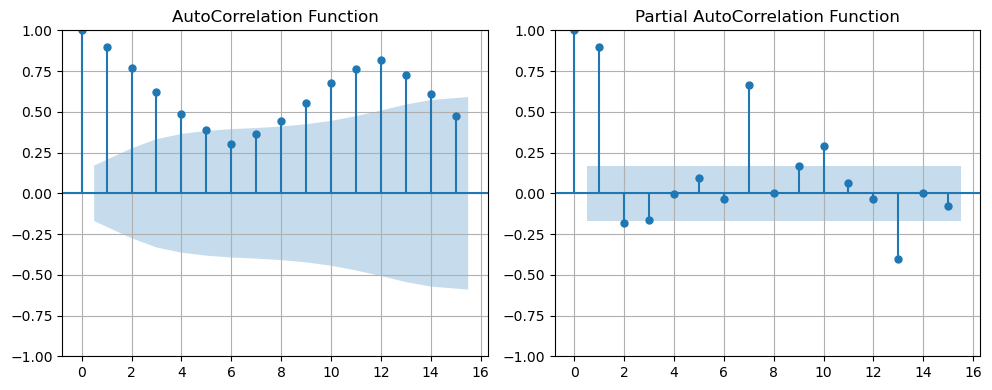

In [16]:
# Create a 1x2 grid for subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))  

# Interest Rate Data
plot_acf(energy_series, ax=axes[0], lags=15)
axes[0].set_title("AutoCorrelation Function", fontsize=12)
axes[0].grid(True)

# Simulated Random Walk Data
plot_pacf(energy_series, ax=axes[1], lags=15)
axes[1].set_title("Partial AutoCorrelation Function", fontsize=12)
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [17]:
# Define the SARIMA (p,d,q)(P,D,Q,S) model
model_022 = SARIMAX(energy_series,                       # Time series data
                    order=(0, 2, 2),                     # Non-seasonal order (p,d,q)
                    seasonal_order=(1, 0, 1, 12),        # Seasonal order (P,D,Q,S)
                    enforce_stationarity=False)          # Allow non-stationary behavior

# Fit the model
model_fit_022 = model_022.fit()

# Display summary of the model
print(model_fit_022.summary())

                                      SARIMAX Results                                       
Dep. Variable:                        Cents_per_kWh   No. Observations:                  132
Model:             SARIMAX(0, 2, 2)x(1, 0, [1], 12)   Log Likelihood                  32.987
Date:                              Wed, 09 Apr 2025   AIC                            -55.973
Time:                                      08:53:54   BIC                            -42.249
Sample:                                  01-01-2001   HQIC                           -50.403
                                       - 12-01-2011                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.3926      0.102    -13.649      0.000      -1.593      -1.193
ma.L2          0.39

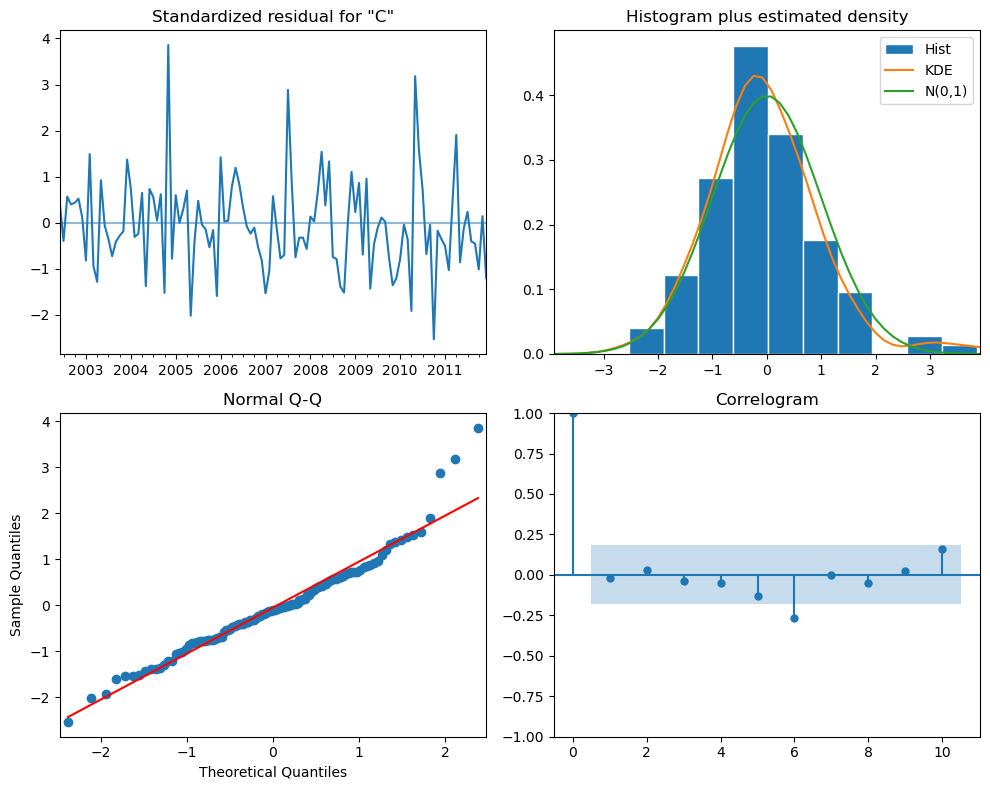

In [18]:
# Extract the residuals (errors) from the fitted model
residuals = model_fit_022.resid  

# Diagnostic plots for the model, including residuals and other model checks
model_fit_022.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show();

In [19]:
# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals

There are p-values < 0.05; Ha: Residuals are autocorrelated.



,lb_stat,lb_pvalue
1,30.691315,3.025160e-08
2,31.197809,1.680668e-07
3,31.397361,7.010695e-07
4,33.148479,1.113719e-06
5,34.202021,2.170361e-06
6,34.612725,5.121655e-06
7,35.004190,1.116417e-05
8,35.601529,2.076832e-05
9,37.729201,1.949298e-05
10,44.013614,3.273183e-06


In [20]:
# Forecast the next 12 time points
forecast_28m = model_fit_022.get_forecast(steps=28)

# Extract predicted mean and confidence intervals
forecast_mean_28 = forecast_28m.predicted_mean
conf_int_28 = forecast_28m.conf_int()

# Assign forecasts to the test DataFrame
test['Forecast'] = forecast_mean_28.values                                # Forecast mean

test['Error'] = test['Forecast'] - test['Cents_per_kWh']

test['Lower 95% CI'] = conf_int_28.iloc[:, 0].values                      # Lower bound
test['Upper 95% CI'] = conf_int_28.iloc[:, 1].values                      # Upper bound

# Show the updated test DataFrame
test

,Cents_per_kWh,Forecast,Error,Lower 95% CI,Upper 95% CI
Date,,,,,
2012-01-01,10.01,9.943795,-0.066205,9.599146,10.288444
2012-02-01,10.26,10.106593,-0.153407,9.702759,10.510427
2012-03-01,10.44,10.331358,-0.108642,9.874588,10.788129
2012-04-01,11.17,10.860301,-0.309699,10.354869,11.365733
2012-05-01,11.88,11.777904,-0.102096,11.226941,12.328867
2012-06-01,11.90,11.755609,-0.144391,11.161517,12.349701
2012-07-01,11.86,11.804118,-0.055882,11.168802,12.439435
2012-08-01,11.83,11.676475,-0.153525,11.001482,12.351469
2012-09-01,11.66,11.567889,-0.092111,10.854500,12.281278


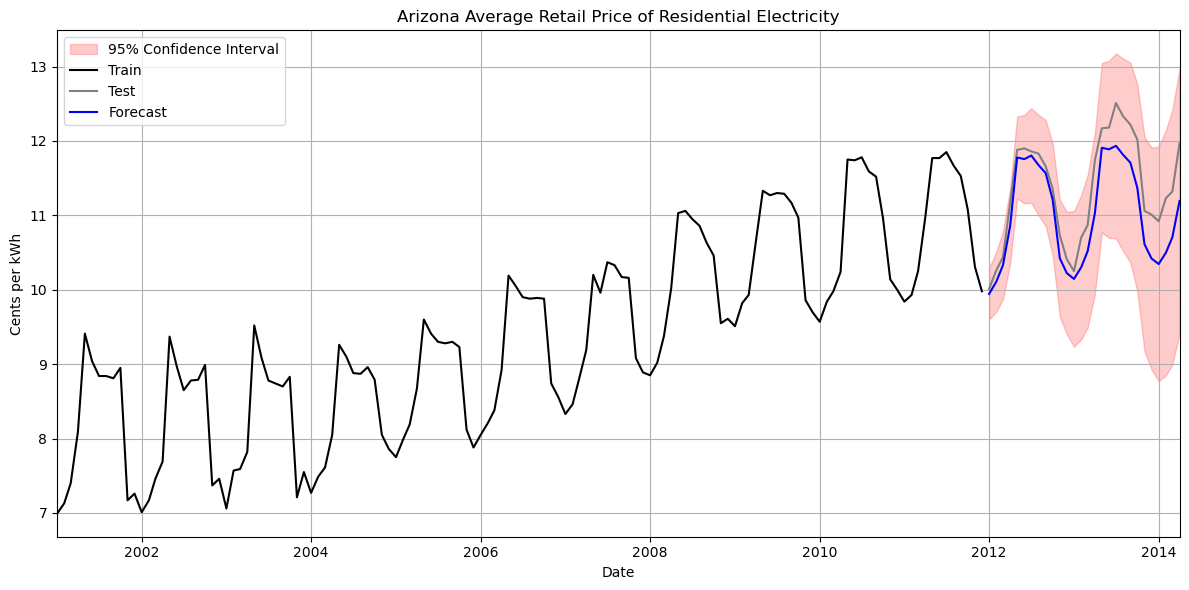

In [21]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

# Plot 95% confidence interval
plt.fill_between(test.index,
                 conf_int_28.iloc[:, 0],     # Lower bound
                 conf_int_28.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.plot(train.index, train['Cents_per_kWh'], label='Train', color='black')       # Train
plt.plot(test.index, test['Cents_per_kWh'], label='Test', color='gray')           # Test

plt.plot(test.index, test['Forecast'], label='Forecast', color='blue')    # Forecast

plt.title('Arizona Average Retail Price of Residential Electricity')                      
plt.xlabel('Date')                                        
plt.ylabel('Cents per kWh')  
plt.xlim(pd.to_datetime('2001-01-01'), pd.to_datetime('2014-04-01'))
plt.grid(True)                                            
plt.legend()                                             
plt.tight_layout()                                       
plt.show();

In [22]:
# Calculate MAPE
mape = (np.abs(test['Error']) / test['Cents_per_kWh']).mean() * 100

# Print the result
print(f"MAPE SARIMA(0,2,2)(1,0,1)[12] model: {mape:.2f}%")

MAPE SARIMA(0,2,2)(1,0,1)[12] model: 3.10%


This means that the `SARIMA(0,2,2)(1,0,1)[12]` model has an average prediction error of 3.10% when applied to our test data. In other words, on average, the model's predictions are off by about 3.10% from the actual values (the `Cents_per_kWh`).